# Low-Resource Neural Machine Translation with transformers.

 # Overview

Abstract

Data and Preprocessing

Model development

Sanity check

Training

Testing

Interpreting The Results

Discussion On Limitations/Issues With Methodologies And Potential Expansions/Fixes

Conclusion

Resources

# Abstract

In this project we will make a sequence to sequence transformer that translates from Bulgarian to English. the model architecture is based on results from studies of neural machine translation most notably [Attention Is All You Need](https://arxiv.org/abs/1706.03762) and [Optimizing Transformer for Low-Resource Neural Machine Translation](https://arxiv.org/abs/2011.02266).

## Utilities ----------------------------------------------------------------|

These are some helper functions to make the model development and training process easier.

### Imports

first our imports

In [949]:
import pickle
import nltk
from nltk.translate.bleu_score import corpus_bleu
nltk.download('punkt')
import math
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from torch.autograd import Variable

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [950]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# drive_path = "/content/gdrive/MyDrive/IT-DL/"
drive_path = ""


In [951]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [952]:
def readCorpus(file_name):

    print('Loading file:', file_name)
    result = [nltk.word_tokenize(line)
              for line in open(file_name, encoding="utf8")]
    return [[w for w in s] for s in result]


def getDictionary(corpus, start_token, end_token, unk_token, pad_token, word_count_threshold=2):

    dictionary = {}
    for s in corpus:
        for w in s:
            if w in dictionary:
                dictionary[w] += 1
            else:
                dictionary[w] = 1

    words = [start_token, end_token, unk_token, pad_token] + \
        [w for w in sorted(dictionary) if dictionary[w] > word_count_threshold]
    return {w: i for i, w in enumerate(words)}


def prepareData(source_file_name, target_file_name, source_dev_file_name, target_dev_file_name, source_test_file_name, target_test_file_name, start_token, end_token, unk_token, pad_token):

    source_corpus = readCorpus(source_file_name)
    target_corpus = readCorpus(target_file_name)
    source_word2ind = getDictionary(
        source_corpus, start_token, end_token, unk_token, pad_token)
    target_word2ind = getDictionary(
        target_corpus, start_token, end_token, unk_token, pad_token)

    target_corpus = [[start_token] + s + [end_token] for s in target_corpus]

    source_dev = readCorpus(source_dev_file_name)
    target_dev = readCorpus(target_dev_file_name)

    target_dev = [[start_token] + s + [end_token] for s in target_dev]

    source_test = readCorpus(source_test_file_name)
    target_test = readCorpus(target_test_file_name)

    target_test = [[start_token] + s + [end_token] for s in target_test]

    print('corpus loading completed.')

    return source_corpus, source_word2ind, target_corpus, target_word2ind, source_dev, target_dev, source_test, target_test


In [953]:
def graphLosses(val_losses):
    fig, ax = plt.subplots(1, 1, figsize=(16, 5))

    ax.plot(val_losses, 'o-', label='Devset')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.set_title('Loss')
    ax.legend()
    plt.show()


# Data and Preprocessing

Our data is a set of 187 000 sentences that are translated from Bulgarian to English. That are split into 180 000 from the training set 1000 for the dev set and 6000 for the test set

In [954]:
SOS = '<SOS>'  # Start of sentence token
EOS = '<EOS>'  # End of sentence token
PAD = '<PAD>'  # Pad token
UNK = '<UNK>'  # Unknown word token


In [955]:
# Uncomment cells below if data is not prepared

# source_corpus, source_word2ind, target_corpus, target_word2ind, source_dev, target_dev, source_test, target_test = \
# prepareData(drive_path + "en_bg_data/train.bg", drive_path + "en_bg_data/train.en", drive_path + "en_bg_data/dev.bg", drive_path + "en_bg_data/dev.en", drive_path + "en_bg_data/test.bg", drive_path + "en_bg_data/test.en", SOS, EOS, UNK, PAD)


In [956]:
# pickle.dump((source_corpus, target_corpus, source_dev, target_dev, source_test, target_test), open(drive_path + "corpusData", 'wb'))
# pickle.dump((source_word2ind, target_word2ind), open(drive_path + "wordsDataFileName", 'wb'))


In [957]:
source_corpus, target_corpus, source_dev, target_dev, source_test, target_test = pickle.load(
    open(drive_path + "corpusData", "rb"))
source_word2ind, target_word2ind = pickle.load(
    open(drive_path + "wordsDataFileName", "rb"))


In [958]:
source_ind2word = {v: k for k, v in source_word2ind.items()}
target_ind2word = {v: k for k, v in target_word2ind.items()}


In [960]:
PAD_IDX = source_word2ind['<PAD>']
SOS_IDX = source_word2ind['<SOS>']
EOS_IDX = source_word2ind['<EOS>']
UNK_IDX = source_word2ind['<UNK>']


We tokenized the data so that we can use only the integer representation of the words and added special tokens that represent padding, start of sentence, end of sentence and unknown word respectively.  

# Model development

To Build our transformer we will need a positional encoding that will let the model take into account the position of a given word in the sentence. 

Each dimension of the positional encoding corresponds to a sinusoid many positional encoding can work but this is the most popular for transformers.

```python

class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 10000):
        super().__init__()
        self.d_model = d_model
        
        # create constant 'pe' matrix with values dependant on 
        # pos and i
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = \
                math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = \
                math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
                
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
 
    
    def forward(self, x):
        # make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        #add constant to embedding
        seq_len = x.size(1)
        x = x + Variable(self.pe[:,:seq_len], \
        requires_grad=False).cuda()
        return x


In [961]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()

        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        x = self.dropout(torch.relu(self.fc_1(x)))

        x = self.fc_2(x)

        return x


The Transformer utilizes multi-head attention in three distinct ways. The first is through "encoder-decoder attention" layers, where the queries are derived from the previous decoder layer and the memory keys and values originate from the encoder output. This enables each position in the decoder to attend to all positions in the input sequence, mimicking encoder-decoder attention mechanisms in sequence-to-sequence models.

The second way is through self-attention layers in the encoder. Within a self-attention layer, all the keys, values, and queries are sourced from the output of the previous encoder layer, allowing each position in the encoder to attend to every position in the prior layer of the encoder.

Similarly, self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position. To maintain the auto-regressive property and prevent leftward information flow in the decoder, illegal connections are masked out in the input of the softmax within the scaled dot-product attention.

In [962]:
class MultiHeadAttentionLayer(torch.nn.Module):
    def __init__(self, hid_dim, heads, dropout, device):
        super().__init__()

        assert hid_dim % heads == 0

        self.hid_dim = hid_dim
        self.heads = heads
        self.head_size = hid_dim // heads

        self.fc_q = torch.nn.Linear(hid_dim, hid_dim, bias=False)
        self.fc_k = torch.nn.Linear(hid_dim, hid_dim, bias=False)
        self.fc_v = torch.nn.Linear(hid_dim, hid_dim, bias=False)

        self.fc_out = torch.nn.Linear(hid_dim, hid_dim)

        self.dropout = torch.nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_size])).to(device)

    def forward(self, query, key, value, mask=None):

        batch_size = query.shape[0]
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        Q = Q.view(batch_size, -1, self.heads,
                   self.head_size).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.heads,
                   self.head_size).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.heads,
                   self.head_size).permute(0, 2, 1, 3)

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim=-1)

        x = torch.matmul(self.dropout(attention), V)

        x = x.permute(0, 2, 1, 3).contiguous()

        x = x.view(batch_size, -1, self.hid_dim)

        x = self.fc_out(x)

        return x, attention


The encoder takes as input a sequence of words, which is first passed through a standard embedding layer, then, since there is no recurrence and the model has no way of knowing the order of the words in the sequence, a second positional embedding layer is used. For the positional coding, I have used a size of 10000 words. In addition to the series of words, a mask is given as input, which has 0 and 1 in the positions where there is a padToken. It is used in the "attention" mechanism, which tells the model not to pay attention to padTokens, which themselves do not carry useful information. Positional embeddings and word embeddings are summed, resulting in a vector containing information about the word itself and its position in the sentence, and before summing, the word embeddings are scaled. They are given to the N layers of the encoder which apply self attention to the source then normalizes it and after that the position wise feed forward layer is applied and second normalization.

In [963]:

class EncoderLayer(torch.nn.Module):
    def __init__(self, hid_dim, heads, pf_dim, dropout, device):
        super().__init__()

        self.self_attn_layer_norm = torch.nn.LayerNorm(hid_dim)
        self.ff_layer_norm = torch.nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(
            hid_dim, heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedForward(
            hid_dim, pf_dim, dropout)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, source, source_mask):

        _source, _ = self.self_attention(source, source, source, source_mask)
        source = self.self_attn_layer_norm(source + self.dropout(_source))

        _source = self.positionwise_feedforward(source)
        source = self.ff_layer_norm(source + self.dropout(_source))

        return source


In [964]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size, hid_dim, layers, heads, pf_dim, dropout, device, max_length=10000):
        super().__init__()

        self.device = device

        self.word_embedding = torch.nn.Embedding(input_size, hid_dim)
        self.pos_embedding = torch.nn.Embedding(max_length, hid_dim)

        self.layers = torch.nn.ModuleList(
            [EncoderLayer(hid_dim, heads, pf_dim, dropout, device) for _ in range(layers)])

        self.dropout = torch.nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, source, source_mask):

        batch_size = source.shape[0]
        source_len = source.shape[1]

        pos = torch.arange(0, source_len).unsqueeze(
            0).repeat(batch_size, 1).to(self.device)

        source = self.dropout((self.word_embedding(
            source) * self.scale) + self.pos_embedding(pos))

        for layer in self.layers:
            source = layer(source, source_mask)

        return source


In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack. Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization. Also the decoder uses both source and target mask so it knows witch part of the source and target sentence to attend to. 

In [965]:
class DecoderLayer(torch.nn.Module):
    def __init__(self, hid_dim, heads, pf_dim, dropout, device):
        super().__init__()

        self.self_attn_layer_norm = torch.nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = torch.nn.LayerNorm(hid_dim)
        self.ff_layer_norm = torch.nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(
            hid_dim, heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(
            hid_dim, heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedForward(
            hid_dim, pf_dim, dropout)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, target, enc_source, target_mask, source_mask):

        _target, _ = self.self_attention(target, target, target, target_mask)
        target = self.self_attn_layer_norm(target + self.dropout(_target))

        _target, attention = self.encoder_attention(
            target, enc_source, enc_source, source_mask)
        target = self.enc_attn_layer_norm(target + self.dropout(_target))

        _target = self.positionwise_feedforward(target)
        target = self.ff_layer_norm(target + self.dropout(_target))

        return target, attention


In [966]:

class Decoder(torch.nn.Module):
    def __init__(self, output_size, hid_dim, layers, heads, pf_dim, dropout, device, max_length=10000):
        super().__init__()

        self.device = device

        self.word_embedding = torch.nn.Embedding(output_size, hid_dim)
        self.pos_embedding = torch.nn.Embedding(max_length, hid_dim)

        self.layers = torch.nn.ModuleList(
            [DecoderLayer(hid_dim, heads, pf_dim, dropout, device) for _ in range(layers)])

        self.fc_out = torch.nn.Linear(hid_dim, output_size)

        self.dropout = torch.nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, target, enc_source, target_mask, source_mask):

        batch_size = target.shape[0]
        target_len = target.shape[1]

        pos = torch.arange(0, target_len).unsqueeze(
            0).repeat(batch_size, 1).to(self.device)

        target = self.dropout((self.word_embedding(
            target) * self.scale) + self.pos_embedding(pos))

        for layer in self.layers:
            target, attention = layer(
                target, enc_source, target_mask, source_mask)

        output = self.fc_out(target)

        return output, attention


In [967]:
class Seq2SeqTransformer(torch.nn.Module):
    def preparePaddedBatch(self, source, word2ind):

        m = max(len(s) for s in source)
        sentences = [[word2ind.get(w, self.unk_token_Idx)
                      for w in s] for s in source]
        sentences_padded = [s+(m-len(s))*[self.pad_token_Idx]
                            for s in sentences]

        return torch.tensor(sentences_padded, dtype=torch.long, device=self.device)

    def save(self, fileName):
        torch.save(self.state_dict(), fileName)

    def load(self, fileName, device):
        self.load_state_dict(torch.load(fileName, map_location=device))

    def makeSourceMask(self, source):
        return (source != self.pad_token_Idx).unsqueeze(1).unsqueeze(2)

    def makeTargetMask(self, target):
        target_pad_mask = (
            target != self.pad_token_Idx).unsqueeze(1).unsqueeze(2)
        target_len = target.shape[1]
        target_sub_mask = torch.tril(torch.ones(
            (target_len, target_len), device=self.device)).bool()
        return target_pad_mask & target_sub_mask

    def __init__(self, encoder, decoder, device, source_word2ind, target_word2ind, start_token, unkToken, padToken, endToken, model_name="model"):
        super(Seq2SeqTransformer, self).__init__()
        self.device = device
        self.source_word2ind = source_word2ind
        self.target_word2ind = target_word2ind
        self.target_ind2Word = {v: k for k, v in target_word2ind.items()}
        self.start_tokenIdx = source_word2ind[start_token]
        self.unk_token_Idx = source_word2ind[unkToken]
        self.pad_token_Idx = source_word2ind[padToken]
        self.end_token_Idx = source_word2ind[endToken]
        self.encoder = encoder
        self.decoder = decoder
        self.model_name = model_name
        self.loss_function = torch.nn.functional.cross_entropy

    def forward(self, source, target):
        source_padded = self.preparePaddedBatch(source, self.source_word2ind)
        target_padded = self.preparePaddedBatch(target, self.target_word2ind)

        source_mask = self.makeSourceMask(source_padded)
        target_mask = self.makeTargetMask(target_padded[:, :-1])

        enc_source = self.encoder(source_padded, source_mask)
        output, attention = self.decoder(
            target_padded[:, :-1], enc_source, target_mask, source_mask)

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        target_padded = target_padded[:, 1:].contiguous().view(-1)

        loss = self.loss_function(
            output, target_padded, ignore_index=self.pad_token_Idx)

        return loss

    def greedyTranslate(self, sentence, limit=1000):

        tokens = [self.source_word2ind[w] if w in self.source_word2ind.keys(
        ) else self.unk_token_Idx for w in sentence]
        source = torch.tensor(tokens, dtype=torch.long,
                              device=self.device).unsqueeze(0)
        source_mask = self.makeSourceMask(source)
        result = [self.start_tokenIdx]

        with torch.no_grad():
            encoder_outputs = self.encoder(source, source_mask)

            for _ in range(limit):
                target = torch.tensor(
                    result, dtype=torch.long, device=self.device).unsqueeze(0)

                target_mask = self.makeTargetMask(target)

                output, attn = self.decoder(
                    target, encoder_outputs, target_mask, source_mask)
                output = output[:, -1, :].squeeze()

                sm = torch.nn.Softmax(0)
                output = sm(output)

                topk = output.topk(2).indices.tolist()

                pred_token = topk[0] if topk[0] != self.unk_token_Idx else topk[1]
                result.append(pred_token)

                if pred_token == self.end_token_Idx:
                    break

        return [self.target_ind2Word[i] for i in result[1:] if i != self.end_token_Idx]


# Training

It's time to workout.

We will regularly evaluate our model's performance and will be saving often incase of a crash. Also we will use a learning rate scheduler to decrease learning rate if we stop seeing performance increases.

In [968]:
def perplexity(model, sourceTest, targetTest, batch_size):

    testSize = len(sourceTest)
    loss = 0.
    c = 0

    for b in range(0, testSize, batch_size):

        sourceBatch = sourceTest[b:min(b+batch_size, testSize)]
        targetBatch = targetTest[b:min(b+batch_size, testSize)]

        l = sum(len(s)-1 for s in targetBatch)
        c += l

        with torch.no_grad():
            loss += l * model(sourceBatch, targetBatch)

    return math.exp(loss/c)


In [969]:
def train_epoch(model, optimizer, idx, batch_size, clip_grad=5, log_every=10):

    iter = 0
    seq_len = len(idx)

    for b in range(0, len(idx), batch_size):
        iter += 1
        sourceBatch = [source_corpus[i]
                       for i in idx[b:min(b+batch_size, len(idx))]]
        targetBatch = [target_corpus[i]
                       for i in idx[b:min(b+batch_size, len(idx))]]

        st = sorted(list(zip(sourceBatch, targetBatch)),
                    key=lambda e: len(e[0]), reverse=True)
        (sourceBatch, targetBatch) = tuple(zip(*st))

        loss = model(sourceBatch, targetBatch)
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

        if iter % log_every == 0:
            print((f"batch: {b}/{seq_len}, Batch loss: {loss.item():5.3f} "))


In [970]:
def train(model, optimizer, learning_rate, num_epochs, batch_size, val_losses=[], clip_grad=5, log_every=10, learning_rate_decay=0.1):

    torch.autograd.set_detect_anomaly(True)
    model.eval()
    bestPerplexity = perplexity(model, source_dev, target_dev, batch_size)
    model.train()

    print("Starting model perplexity: ", bestPerplexity)

    idx = np.arange(len(source_corpus), dtype='int32')
    for i in range(num_epochs):

        np.random.shuffle(idx)

        start_time = timer()
        train_epoch(model, optimizer, idx, batch_size, clip_grad, log_every)
        end_time = timer()

        model.eval()
        currentPerplexity = perplexity(
            model, source_dev, target_dev, batch_size)
        model.train()

        print("Epoch: ", i+1, ' Current model perplexity: ',
              currentPerplexity, "time: ", (start_time - end_time))

        if currentPerplexity < bestPerplexity:

            bestPerplexity = currentPerplexity
            print('Saving new best model.')
            model.save(drive_path + model.model_name)
            torch.save((bestPerplexity, learning_rate, optimizer.state_dict(
            )), drive_path + model.model_name + '.optim')
            val_losses.append(bestPerplexity)
            torch.save((val_losses), drive_path + model.model_name + '_losses')

        else:
            learning_rate *= learning_rate_decay
            print('load previously best model and decay learning rate to:', learning_rate)
            model.load(drive_path + model.model_name, device)
            (bestPerplexity, _, osd) = torch.load(
                drive_path + model.model_name + '.optim')
            val_losses = torch.load(drive_path + model.model_name + '_losses')
            optimizer.load_state_dict(osd)

            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate


The model parameters are based on the finding of from [Optimizing Transformer for Low-Resource Neural Machine Translation](https://arxiv.org/abs/2011.02266).

We will build our starting model based on their best model for their 160 000 sentences dataset since that is most similar to the size of ours. 

The main difference compared to theirs is that we will use a batch size of between 32-64 due to limited recourses. 
Despite the fact that they gained significant performance increases from increasing their batch size to amounts as big as 1 228.

Unfortunately that model did not achieve good results it started to overfit the data very quickly and training was extremely slow ( Perplexity was around 9 ). This may be due to differences in the data Bg to En is not the same as De to En. Also it is likely it's due to the difference in batch size their large batch size probably added regularization to the model. Their model for the 80 000 sentences  dataset also did not achieve good results training was slow and the model didn't manage to achieve good perplexity ( around 9 ). From that point on it was opted to experiment with slightly shallower and wider models ( less layers and more heads and larger embedding dimension )

Note that the learning rate has been was changed during training depending of the models learning speed.

## Model V1

In [971]:
source_vocab_size = len(source_word2ind)
tgt_vocab_size = len(target_word2ind)


In [972]:
num_encoder_layers = 3
num_decoder_layers = 3
emb_size = 128

nhead = 8
dim_feed_forward = 1024
dropout = 0.1

encoder = Encoder(
    source_vocab_size,
    emb_size,
    num_encoder_layers,
    nhead,
    dim_feed_forward,
    dropout,
    device)

decoder = Decoder(
    tgt_vocab_size,
    emb_size,
    num_decoder_layers,
    nhead,
    dim_feed_forward,
    dropout,
    device)

learning_rate = 0.0001
model = Seq2SeqTransformer(encoder, decoder, device, source_word2ind,
                           target_word2ind, SOS, UNK, PAD, EOS, model_name="T1").to(device)
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)


In [973]:
model.load(drive_path + model.model_name, device)
(bestPerplexity, learning_rate, osd) = torch.load(
    drive_path + model.model_name + '.optim')
val_losses = torch.load(drive_path + model.model_name + '_losses')
optimizer.load_state_dict(osd)


In [974]:
# val_losses = []
# train(model, optimizer, learning_rate, 30, 64, val_losses, clip_grad = 10, log_every = 10, learning_rate_decay = 0.1)


In [975]:
print(bestPerplexity)


6.517712046628565


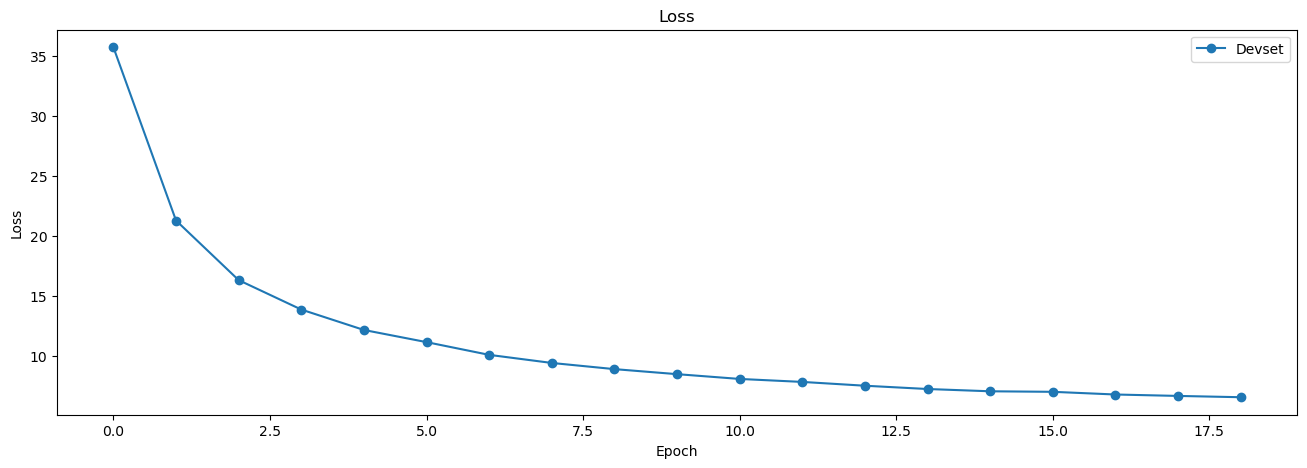

In [976]:
graphLosses(val_losses)


Epoch time ~15 min.

We see very good performance compared to previous models but still the model seems it too simle for the data we consistently had better performance on the dev set compared to the training. So it was opted for a slightly more complex model with larger embedding and feed forward dimensions. 

## Model V2

In [977]:
num_encoder_layers = 3
num_decoder_layers = 3
emb_size = 256

nhead = 8
dim_feedforward = 2048
dropout = 0.1

encoder = Encoder(
    source_vocab_size,
    emb_size,
    num_encoder_layers,
    nhead,
    dim_feedforward,
    dropout,
    device)

decoder = Decoder(
    tgt_vocab_size,
    emb_size,
    num_decoder_layers,
    nhead,
    dim_feedforward,
    dropout,
    device)

learning_rate = 0.0001
model2 = Seq2SeqTransformer(encoder, decoder, device, source_word2ind,
                            target_word2ind, SOS, UNK, PAD, EOS, "T2").to(device)
optimizer2 = torch.optim.Adam(
    model2.parameters(), lr=learning_rate, betas=(0.9, 0.98))


In [978]:
model2.load(drive_path + model2.model_name, device)
(bestPerplexity, learning_rate, osd) = torch.load(
    drive_path + model2.model_name + '.optim')
val_losses = torch.load(drive_path + model2.model_name + '_losses')
optimizer.load_state_dict(osd)


In [979]:
# val_losses = []
# train(model, optimizer, learning_rate, 30, 64, val_losses, clip_grad = 10, log_every = 10, learning_rate_decay = 0.1)


In [980]:
print(bestPerplexity)


4.730056733037377


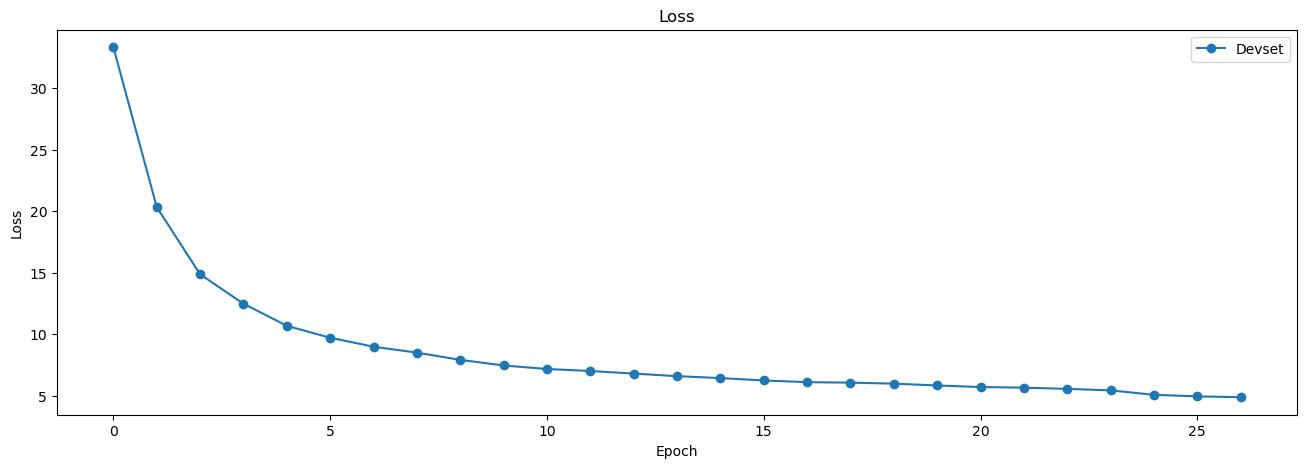

In [981]:
graphLosses(val_losses)


Epoch time ~20 min.

Again we see significant improvement And again the model was perplexity was the same or lower on the dev set compared to the training so we again opted for a more complex model hoping that we will achieve better results.

## Model V2 Extra trained

In [982]:
num_encoder_layers = 3
num_decoder_layers = 3
emb_size = 256

nhead = 8
dim_feedforward = 2048
dropout = 0.1

encoder = Encoder(
    source_vocab_size,
    emb_size,
    num_encoder_layers,
    nhead,
    dim_feedforward,
    dropout,
    device)

decoder = Decoder(
    tgt_vocab_size,
    emb_size,
    num_decoder_layers,
    nhead,
    dim_feedforward,
    dropout,
    device)

learning_rate = 0.0001
model2_V2 = Seq2SeqTransformer(encoder, decoder, device, source_word2ind,
                               target_word2ind, SOS, UNK, PAD, EOS, "T2V2").to(device)
optimizer2_V2 = torch.optim.Adam(
    model2.parameters(), lr=learning_rate, betas=(0.9, 0.98))


In [983]:
model2_V2.load(drive_path + model2_V2.model_name, device)
(bestPerplexity, learning_rate, osd) = torch.load(
    drive_path + model2_V2.model_name + '.optim')
val_losses = torch.load(drive_path + model2_V2.model_name + '_losses')
optimizer2_V2.load_state_dict(osd)


In [984]:
# val_losses = []
# train(model, optimizer, learning_rate, 30, 64, val_losses, clip_grad = 10, log_every = 10, learning_rate_decay = 0.1)


In [985]:
print(bestPerplexity)


4.565630926646202


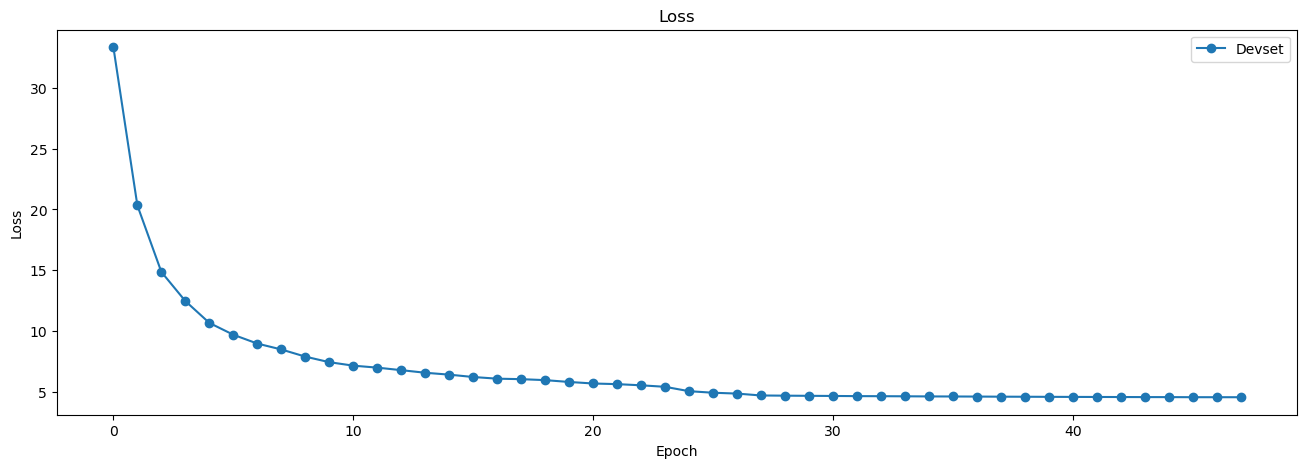

In [986]:
graphLosses(val_losses)


## Model V3

In [987]:
num_encoder_layers = 3
num_decoder_layers = 3
emb_size = 512

nhead = 8
dim_feedforward = 2048
dropout = 0.2

encoder = Encoder(
    source_vocab_size,
    emb_size,
    num_encoder_layers,
    nhead,
    dim_feedforward,
    dropout,
    device)

decoder = Decoder(
    tgt_vocab_size,
    emb_size,
    num_decoder_layers,
    nhead,
    dim_feedforward,
    dropout,
    device)

learning_rate = 0.0001
model3 = Seq2SeqTransformer(encoder, decoder, device, source_word2ind,
                            target_word2ind, SOS, UNK, PAD, EOS, "T3").to(device)
optimizer3 = torch.optim.Adam(
    model3.parameters(), lr=learning_rate, betas=(0.9, 0.98))


In [988]:
model3.load(drive_path + model3.model_name, device)
(bestPerplexity, learning_rate, osd) = torch.load(
    drive_path + model3.model_name + '.optim')
val_losses = torch.load(drive_path + model3.model_name + '_losses')
optimizer.load_state_dict(osd)


In [989]:
# val_losses = []
# train(model, optimizer, learning_rate, 30, 64, val_losses, clip_grad = 10, log_every = 10, learning_rate_decay = 0.1)


In [990]:
print(bestPerplexity)


6.101510058530434


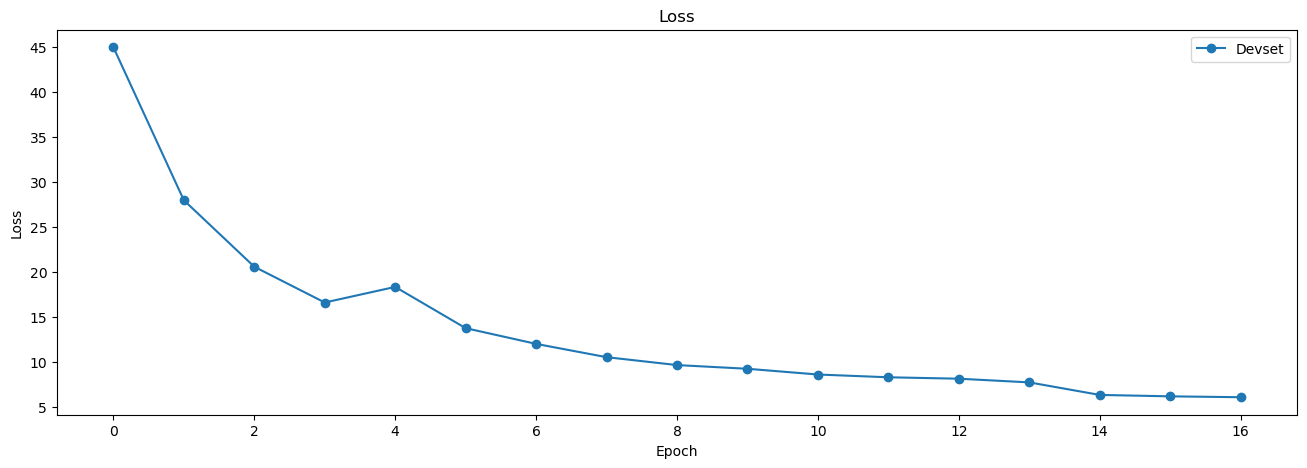

In [991]:
graphLosses(val_losses)


Epoch time ~30 min.

Unfortunately here this was not the case the model was very unstable and did not achieve better results despite it's increased complexity.

After that it was opted for a even more shallow model with wider embedding dimension hoping that it would help with training speed.

## Model V4

In [992]:
num_encoder_layers = 2
num_decoder_layers = 2
emb_size = 512

nhead = 8
dim_feedforward = 2048
dropout = 0.1

encoder = Encoder(
    source_vocab_size,
    emb_size,
    num_encoder_layers,
    nhead,
    dim_feedforward,
    dropout,
    device)

decoder = Decoder(
    tgt_vocab_size,
    emb_size,
    num_decoder_layers,
    nhead,
    dim_feedforward,
    dropout,
    device)

learning_rate = 0.0001
model4 = Seq2SeqTransformer(encoder, decoder, device, source_word2ind,
                            target_word2ind, SOS, UNK, PAD, EOS, "T4").to(device)
optimizer4 = torch.optim.Adam(
    model4.parameters(), lr=learning_rate, betas=(0.9, 0.98))


In [993]:
model4.load(drive_path + model4.model_name, device)
(bestPerplexity, learning_rate, osd) = torch.load(
    drive_path + model4.model_name + '.optim')
val_losses = torch.load(drive_path + model4.model_name + '_losses')
optimizer4.load_state_dict(osd)


In [994]:
# val_losses = []
# train(model, optimizer, learning_rate, 30, 64, val_losses, clip_grad = 10, log_every = 10, learning_rate_decay = 0.1)


In [995]:
print(bestPerplexity)


12.61146370697793


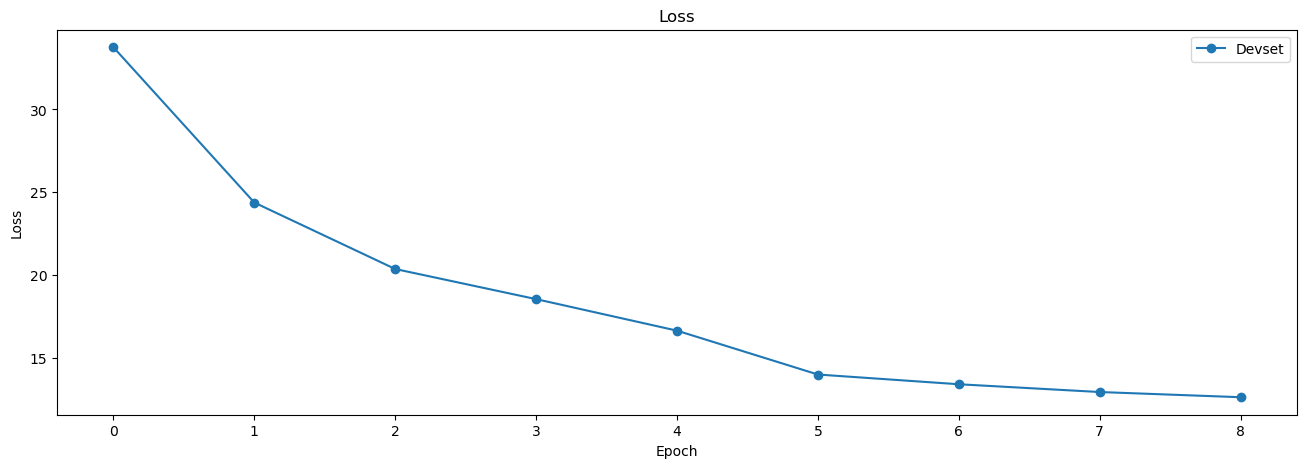

In [996]:
graphLosses(val_losses)


Epoch time ~15 min.

Again that model didn't show promising results compared to the previous models.

## Model V5

In [997]:
num_encoder_layers = 4
num_decoder_layers = 4
emb_size = 128

nhead = 8
dim_feedforward = 2048
dropout = 0.1

encoder = Encoder(
    source_vocab_size,
    emb_size,
    num_encoder_layers,
    nhead,
    dim_feedforward,
    dropout,
    device)

decoder = Decoder(
    tgt_vocab_size,
    emb_size,
    num_decoder_layers,
    nhead,
    dim_feedforward,
    dropout,
    device)

learning_rate = 0.0001
model5 = Seq2SeqTransformer(encoder, decoder, device, source_word2ind,
                            target_word2ind, SOS, UNK, PAD, EOS, "T5").to(device)
optimizer5 = torch.optim.Adam(
    model5.parameters(), lr=learning_rate, betas=(0.9, 0.98))


In [998]:
model5.load(drive_path + model5.model_name, device)
(bestPerplexity, learning_rate, osd) = torch.load(
    drive_path + model5.model_name + '.optim')
val_losses = torch.load(drive_path + model5.model_name + '_losses')
optimizer5.load_state_dict(osd)


In [999]:
# val_losses = []
# train(model, optimizer, learning_rate, 30, 64, val_losses, clip_grad = 10, log_every = 10, learning_rate_decay = 0.1)


In [1000]:
print(bestPerplexity)


16.345473919843617


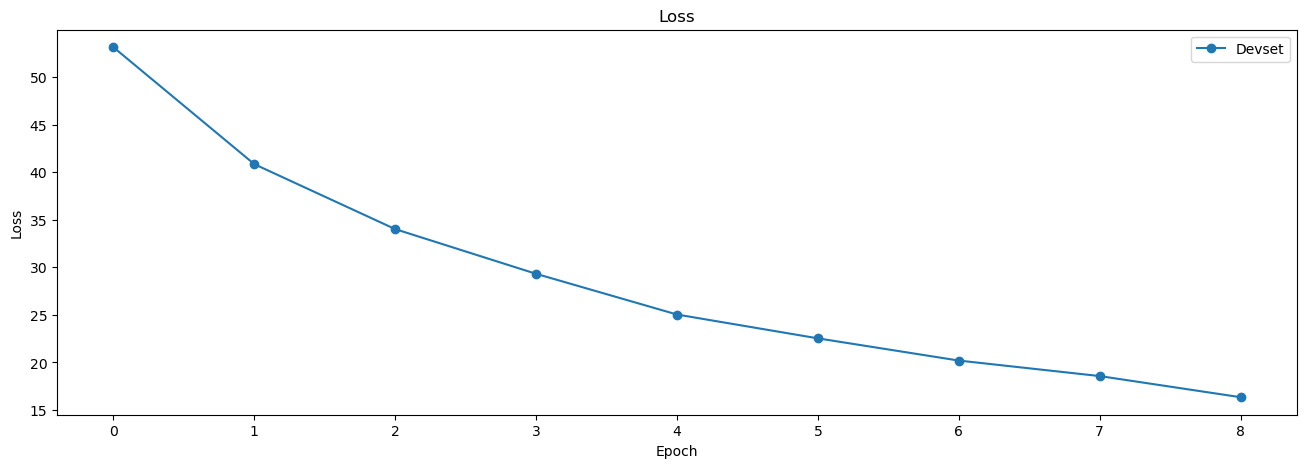

In [1001]:
graphLosses(val_losses)


About ~30 min per epoch.

After that the model got stuck.

# Testing And Interpreting The Results

In [1002]:
def translate(model, source_filename, target_filename, limit=1000):
    sourceTest = readCorpus(source_filename)

    model.eval()
    file = open(target_filename, 'w')

    for s in sourceTest:
        file.write(' '.join(model.greedyTranslate(s, limit))+"\n")


In [1003]:
def beamTranslate(model, source_filename, target_filename, beam_width=3, alpha=.99, limit=1000):
    sourceTest = readCorpus(source_filename)

    model.eval()
    file = open(target_filename, 'w')

    for s in sourceTest:
        file.write(' '.join(model.beam(s, beam_width, alpha, limit))+"\n")


In [1004]:
def calculateBlue(source_filename, target_filename):
    ref = [[s] for s in readCorpus(source_filename)]
    hyp = readCorpus(target_filename)

    bleu_score = corpus_bleu(ref, hyp)
    print('Corpus BLEU: ', (bleu_score * 100))


## Model 1

In [1005]:
# translate(model, "en_bg_data/test.bg", "model1Translation/test", limit = 1000)


Translation time ~43 min

Note translations were made on a less capable machine.

In [1006]:
calculateBlue("en_bg_data/test.en", "model1Translation/test")


Loading file: en_bg_data/test.en
Loading file: model1Translation/test
Corpus BLEU:  31.35249672993427


Our fist model has a blue score og 31.35 witch is comparable with the results in [Optimizing Transformer for Low-Resource Neural Machine Translation](https://arxiv.org/abs/2011.02266). 

## Model 2

In [1007]:
# translate(model2, "en_bg_data/test.bg", "model2Translation/test", limit = 1000)


Translation time ~32 min

In [1008]:
calculateBlue("en_bg_data/test.en", "model2Translation/test")


Loading file: en_bg_data/test.en
Loading file: model2Translation/test
Corpus BLEU:  35.88492214352221


Our second model has a blue score og 35.88 witch is larger that the beat result achieved in [Optimizing Transformer for Low-Resource Neural Machine Translation](https://arxiv.org/abs/2011.02266) ( 35.2 ). 

In [1009]:
# translate(model2_V2, "en_bg_data/test.bg", "model2Translation/testV2", limit = 1000)


In [1010]:
calculateBlue("en_bg_data/test.en", "model2Translation/testV2")


Loading file: en_bg_data/test.en
Loading file: model2Translation/testV2
Corpus BLEU:  36.695843112579766


## Model 3

In [1011]:
# translate(model3, "en_bg_data/test.bg", "model3Translation/test", limit = 1000)


In [1012]:
calculateBlue("en_bg_data/test.en", "model3Translation/test")


Loading file: en_bg_data/test.en
Loading file: model3Translation/test
Corpus BLEU:  29.63762177971894


## Model 4

In [1013]:
# translate(model4, "en_bg_data/test.bg", "model4Translation/test", limit = 1000)


In [1014]:
calculateBlue("en_bg_data/test.en", "model4Translation/test")


Loading file: en_bg_data/test.en
Loading file: model4Translation/test
Corpus BLEU:  18.483327403909367


# Discussion On Limitations/Issues With Methodologies And Potential Expansions/Fixes

As with pretty much any AI model more data and more processing power would have improved the final models performance. Obviously using positional encoding would have improved the models performance . Also using maybe a less chaotic approach to choosing our hyper parameters by using something like limited grid search. Also trying different Transformer architectures which might be more efficient or perform better and comparing the with an LSTM decoder encoder model to see if we also would have achieved similar results like in [Massive Exploration of Neural Machine Translation Architectures](https://aclanthology.org/D17-1151/).

# Conclusion

We didn't have an RNN based model to compare our results to but using a corpus of less that 190 000 sentences we managed to achieve a very respectable Blue score ( > 35 ) even without positional encoding. Which shows that a fairly good neural machine translation model can be created with a surprisingly small amount of data and processing power. 

# Resources

[Optimizing Transformer for Low-Resource Neural Machine Translation](https://arxiv.org/abs/2011.02266)

[Attention Is All You Need](https://arxiv.org/abs/1706.03762)

[Massive Exploration of Neural Machine Translation Architectures](https://aclanthology.org/D17-1151/)

[Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)

[Achieving Open Vocabulary Neural Machine Translation with Hybrid Word-Character Models](https://aclanthology.org/P16-1100/)

[Pytorch](https://pytorch.org)

https://github.com/bentrevett/pytorch-seq2seq/blob/master/6%20-%20Attention%20is%20All%20You%20Need.ipynb